In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon

from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_oscillation

from timescales.sim import sim_spikes_synaptic
from timescales.optimize import fit_grid
from timescales.plts import plot_connected_scatter
from timescales.fit import compute_acf, convert_knee_val

### Simulate

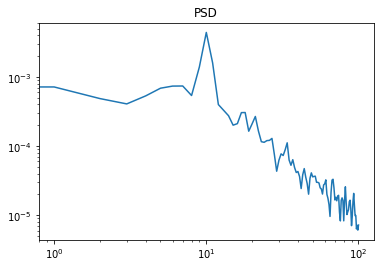

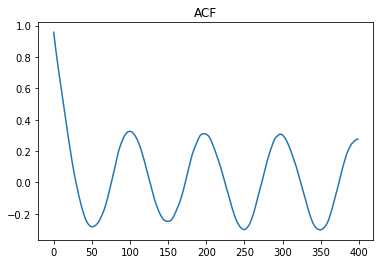

In [2]:
# Add oscillation
np.random.seed(0)

n_seconds = 10
fs = 1000
tau = convert_knee_val(10) #10hz knee
mu = 100
std = 100

isi = expon.rvs(size=int(n_seconds * fs))
isi -= isi.mean()
isi = isi * std + mu
isi = np.round_(isi).astype(int)

probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1, isi=isi, return_sum=False)

# Add oscillation
cos = sim_oscillation(n_seconds, fs, 10, phase='max')
cos -= cos.min()
cos /= cos.max()

sig = probs + (cos * .2)

f, p = compute_spectrum(sig, fs, f_range=(0, 100))

plt.figure(0)
plt.loglog(f, p)
plt.title('PSD')

plt.figure(1)
corrs = compute_acf(sig, 400)
plt.plot(corrs)
plt.title('ACF');

### Fit Grid

In [3]:
# 120,000 combinations
specparam_grid = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 10, 2), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': np.column_stack((np.arange(0, 100, 10), np.arange(0, 100, 10)+20))[:-1],
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.array([[0, 100]])#np.column_stack((np.zeros(10), np.arange(10, 110, 10)))
}

In [4]:
# Randomly sample 10000 combinations
params = fit_grid(sig, fs, specparam_grid, mode='psd', max_n_params=int(1e4),
                  n_jobs=-1, chunksize=20)

Fitting Spectra or ACF:   0%|          | 0/10000 [00:00<?, ?it/s]

### Visualize Results

The most important parameter to tune is `knee_freq_bounds`. When this param is constrained to the ground truth range (i.e. 5-15 Hertz), most timescales are estimated within an appropriate range and the mean of the parameter grid approaches ground truth. The full model R^2 alone can't differentiate between appropriate parameter sets. 

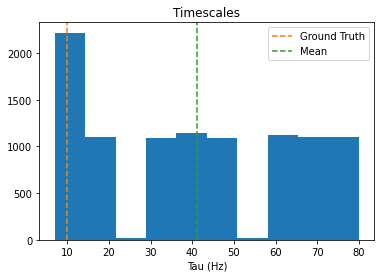

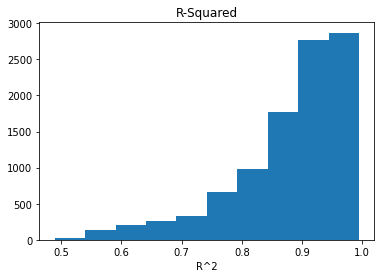

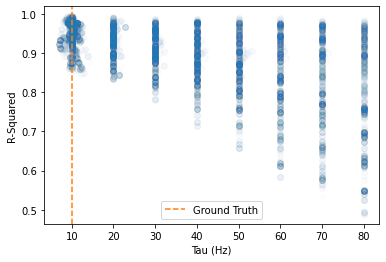

In [5]:
knees = np.array([convert_knee_val(i[1]) for i in params])
knee_freqs = np.array([i[1] for i in params])
rsqs = np.array([p[2] for p in params])

plt.figure(0)
plt.hist(knee_freqs)
plt.axvline(10, ls='--', color='C1', label='Ground Truth')
plt.axvline(np.mean(knee_freqs), ls='--', color='C2', label='Mean')
plt.title('Timescales')
plt.xlabel('Tau (Hz)')
plt.legend()

plt.figure(1)
rsqs = np.array([p[2] for p in params])
plt.hist(rsqs)
plt.title('R-Squared')
plt.xlabel('R^2')

plt.figure(2)
plt.scatter(knee_freqs, rsqs, alpha=.01)
plt.xlabel('Tau (Hz)')
plt.ylabel('R-Squared')
plt.axvline(10, color='C1', ls='--', label='Ground Truth')
plt.legend();

### R-Squared: Full vs Aperiodic
Next, we look into a way to determined "good" vs "bad" fits, using something other than full model r-squared, which isn't descriminative enough. The proposed measure is the r^2 of the aperiodic component - this assumes the model that minimizes peak power (or the model with most baseline aperiodic power) is preferred. The 10 Hz knee is best captured when the knee is limited to 0-20 Hz. This may be quantified without a priori assumptions by maximizing the aperiodic r-squared.

In [6]:
# R-squared
r_squared_full = np.array([p[2] for p in params])

r_squared_ap = np.zeros(len(params))
r_squared_ap[:] = np.nan

for ind, p in enumerate(params):
     
    # If not nan
    if not isinstance(p[3], float):
        r_val = np.corrcoef(p[3].power_spectrum, p[3]._ap_fit)
        r_squared_ap[ind] = r_val[0][1] ** 2

# Knee range grid indices
knee_param_inds = np.array([p[0][3] for p in params])

Below, we see that while most full model fits have a high r-squared, the aperiodic r-squared has greater variance. This variance will subsequently be used to determine appropriate parameters in the grid - specifically narrowing in on the knee bounds range.

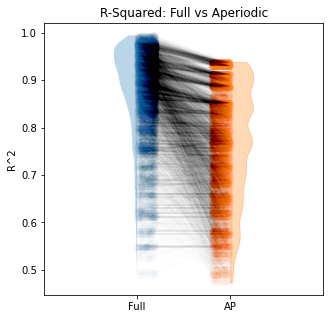

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

plot_connected_scatter(r_squared_full, r_squared_ap, ax, 'R-Squared: Full vs Aperiodic',
                       ylabel='R^2', xticklabels=['Full', 'AP'], alpha_line=.005, alpha_scatter=.01);

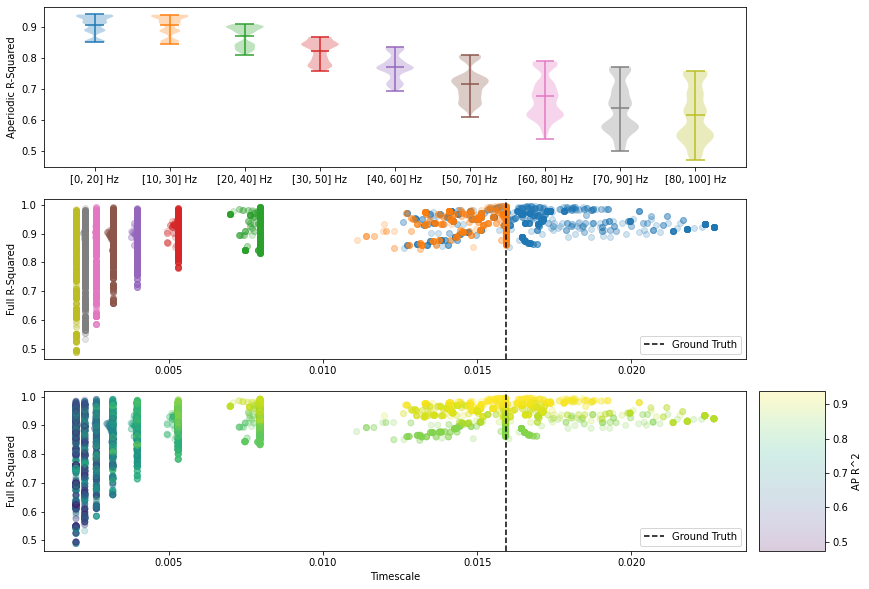

In [8]:
fig = plt.figure(figsize=(14, 10))

gs = fig.add_gridspec(nrows=3, ncols=10)

ax0 = fig.add_subplot(gs[0, :9])
ax1 = fig.add_subplot(gs[1, :9])
ax2 = fig.add_subplot(gs[2, :9])
ax3 = fig.add_subplot(gs[2, 9:])


for i in np.unique(knee_param_inds):
    ax0.violinplot(r_squared_ap[np.where(knee_param_inds == i)[0]], positions=[i+1], showmeans=True)
    
ax0.set_xticks(np.arange(1, len(specparam_grid['knee_freq_bounds'])+1))
ax0.set_xticklabels([str(i) + ' Hz' for i in specparam_grid['knee_freq_bounds'].tolist()]) 
ax0.set_ylabel('Aperiodic R-Squared')


colors = ['C'+str(i) for i in range(len(specparam_grid['knee_freq_bounds']))]

for i, c in zip(np.unique(knee_param_inds), colors):
    inds = np.where(knee_param_inds == i)[0]
    ax1.scatter(knees[inds], rsqs[inds], alpha=.2, c=c)
    
ax1.set_ylabel('Full R-Squared')
ax1.axvline(tau, color='k', ls='--', label='Ground Truth')
ax1.legend()


sc = ax2.scatter(knees, rsqs, alpha=.2, c=r_squared_ap)
cbar = plt.colorbar(sc, ax=ax2, use_gridspec=True, cax=ax3)
ax3.set_ylabel('AP R^2')

ax2.set_xlabel('Timescale')
ax2.set_ylabel('Full R-Squared')
ax2.axvline(tau, color='k', ls='--', label='Ground Truth')
ax2.legend();

### PSD: Restricting the Grid

Next, the parameter grid is restricted by setting the knee range to (0, 20) Hz, as determined aboved. This reduces the grid size to 12,000 combinations, from 120,000. The mean of the timescale distribution, from all other parameter combinations, approaches ground truth. This may offer an alternative to Zeraati 2022, assuming sampling a variety of spectral and spectral fitting parameters removes finite duration bias via central limit theorem.

Once the knee frequency bounds range is appropriatly confined, the tau distribution of all other combinations approaches ground truth.

In [9]:
# Restrict grid based on knee range
r2_per_knee_band = np.array([r_squared_ap[np.where(knee_param_inds == i)[0]].mean()
                              for i in np.unique(knee_param_inds)])

knee_freq_bounds = np.array([specparam_grid['knee_freq_bounds'][r2_per_knee_band.argmax()]])

specparam_grid_restrict = {
    # Init kwargs
    'peak_width_limits': np.array(list(combinations(np.arange(1, 10, 2), 2))),
    'max_n_peaks': np.arange(1, 13, 3),
    'peak_threshold': np.arange(1, 5),
    # Self kwargs (post-init)
    'knee_freq_bounds': knee_freq_bounds,
    'exp_bounds': np.column_stack((np.array([.01, 1, 2]), np.arange(2, 5))),
    # Compute spectra kwargs
    'nperseg': (np.linspace(.5, 1.5, 5) * fs).astype(int),
    'noverlap': np.arange(0, 10, 2)/10,
    # Fit kwargs
    'freq_range': np.array([[0, 100]]) #np.column_stack((np.zeros(10), np.arange(10, 110, 10)))
}

params = fit_grid(sig, fs, specparam_grid_restrict, mode='psd',
                  n_jobs=-1, chunksize=20)

Fitting Spectra or ACF:   0%|          | 0/12000 [00:00<?, ?it/s]

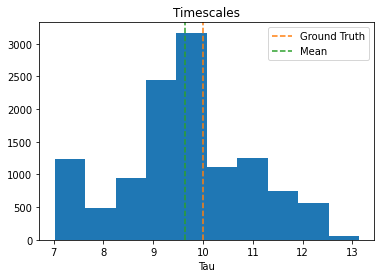

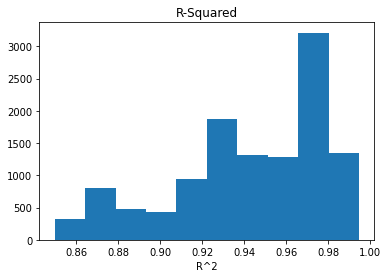

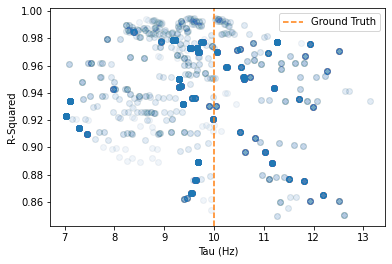

In [10]:
knees = np.array([convert_knee_val(i[1]) for i in params])
knee_freqs = np.array([i[1] for i in params])
rsqs = np.array([p[2] for p in params])

plt.figure(0)
plt.hist(knee_freqs)
plt.axvline(10, ls='--', color='C1', label='Ground Truth')
plt.axvline(np.mean(knee_freqs), ls='--', color='C2', label='Mean')
plt.title('Timescales')
plt.xlabel('Tau')
plt.legend()

plt.figure(1)
plt.hist(rsqs)
plt.title('R-Squared')
plt.xlabel('R^2')

plt.figure(2)
plt.scatter(knee_freqs, rsqs, alpha=.01)
plt.xlabel('Tau (Hz)')
plt.ylabel('R-Squared')
plt.axvline(10, color='C1', ls='--', label='Ground Truth')
plt.legend();

## Autocorrelation Tuning

Similar to SpecParam, ACF fitting may produce high r-squared fits with incorrect timescales. This is likely due to the exponential decay term of the damped cosine that compensates (the true tau may be the sum of two exponential decay components). The confounding effect of the second decay term makes this a harder problem to optimize.

Additionally, the oscillitory component spans across all ACF lags, whereas the oscillitory component is more confined to the 10Hz +/- a few Hz in the PSD. This makes optimization easier with PSD. Thus, the recommendation is to use PSD to confine the tau bounds.

In [11]:
# Set knee tau bounds - same as knee freq bounds
knee_freq_bounds = specparam_grid['knee_freq_bounds']
knee_freq_bounds[0][0] = 1 # avoid inf from 0 Hz
tau_bounds = np.array([[convert_knee_val(k) for k in knee_freq_bounds[0][::-1]]])

# Set oscillitory damped decay rate bounds
osc_tau_bounds = np.array([convert_knee_val(i) for i in knee_freq_bounds.T[::-1].T])


acf_grid = {
    # ACF params
    'nlags': (np.linspace(0, 1, 9)[1:] * fs).astype(int),
    # Exponential decay param
    'exp_tau': tau_bounds,
    # Oscillatory params
    'osc_tau': np.array([
        [.2, .6],
        [.4, .8],
        [.6, 1.],
        [.8, 1.2]
    ]),
    'osc_gamma': np.array([
        [.4, .8],
        [.6, 1],
        [.8, 1.2],
        [1, 1.4]
    ]),
    'freq': np.array([
        [None, None],
    ]),
    # Scaling and offset params
    'amp_ratio': np.array([
        [.2, .6],
        [.6, .8],
        [.8, 1.]
        
    ]),
    'height': np.array([
        [.2, .8],
        [.4, 1],
        [.6, 1.2],
        [.8, 1.4]
    ]),
    'offset': np.array([
        [-1, 1]
    ])
}

In [12]:
params = fit_grid(sig, fs, acf_grid, mode='acf', max_n_params=5000,
                  n_jobs=-1, chunksize=1, rsq_thresh=0.5)

# Remove poor fits
low_inds = np.where(np.isnan([p[1] for p in params]))[0]
params = [p for ind, p in enumerate(params) if ind not in low_inds]

Fitting Spectra or ACF:   0%|          | 0/1536 [00:00<?, ?it/s]

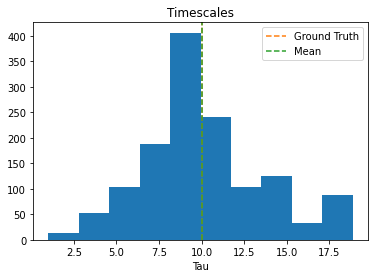

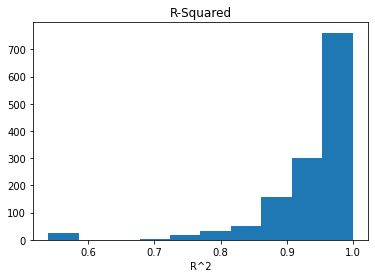

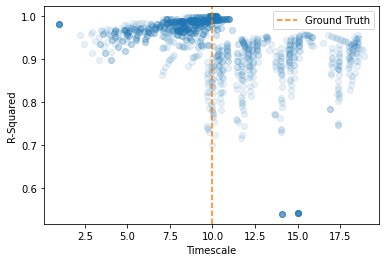

In [13]:
knees = np.array([convert_knee_val(i[1]) for i in params])
knee_freqs = np.array([i[1] for i in params])
rsqs = np.array([p[2] for p in params])

plt.figure(0)
plt.hist(knee_freqs)
plt.axvline(10, ls='--', color='C1', label='Ground Truth', alpha=1)
plt.axvline(np.mean(knee_freqs), ls='--', color='C2', label='Mean', alpha=1)
plt.title('Timescales')
plt.xlabel('Tau')
plt.legend()

plt.figure(1)
plt.hist(rsqs)
plt.title('R-Squared')
plt.xlabel('R^2')

plt.figure(2)
plt.scatter(knee_freqs, rsqs, alpha=.1)
plt.xlabel('Timescale')
plt.ylabel('R-Squared')
plt.axvline(10, color='C1', ls='--', label='Ground Truth')
plt.legend();